# Compare fit results to published values

This notebook compares fit results from SNCosmo with fit results published by SDSS and DES.

In [ ]:
import os
import sys
from copy import deepcopy

import numpy as np
import pandas as pd
import sncosmo
from astropy.table import Table, join
from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from matplotlib import pyplot as plt

sys.path.insert(0, '../')
from analysis_pipeline.data_access import sdss, des, csp
from analysis_pipeline import SN91bgSource
from analysis_pipeline.lc_fitting import split_data
from read_pipeline_outputs import get_fit_results


In [ ]:
# Set up bokeh plotting
output_notebook()
_basic_tools = "save,pan,box_zoom,reset,wheel_zoom".split(',')

# Output directory for figures
fig_dir = './notebook_figs'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
    
# Directory of fit results
data_dir = '../fit_results'

# Define models
salt_2_4 = sncosmo.Model(source=sncosmo.get_source('salt2', version='2.4'))
salt_2_0 = sncosmo.Model(source=sncosmo.get_source('salt2', version='2.0'))
sn_91bg = sncosmo.Model(source=SN91bgSource())


# Plot Single Target

Plot fitted model for a single target.


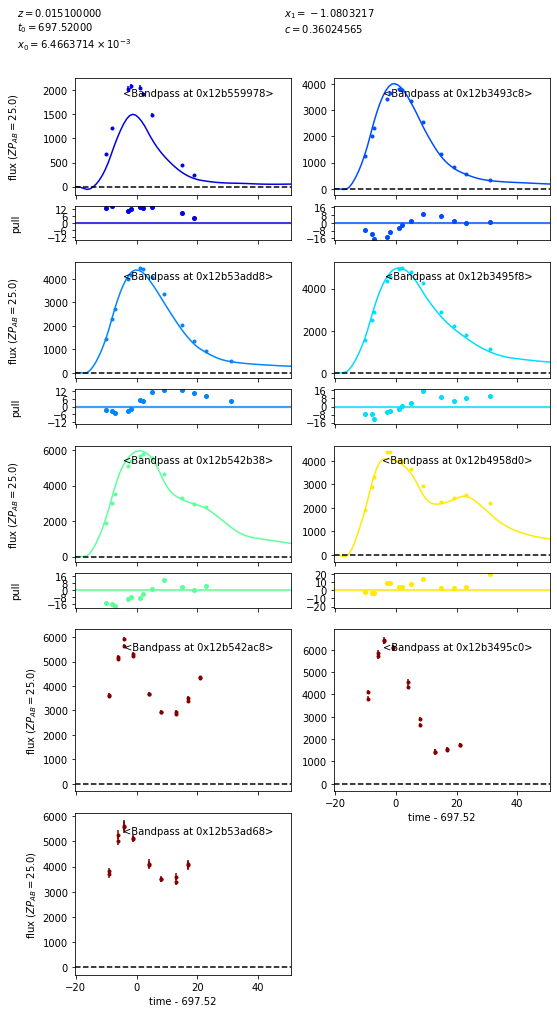

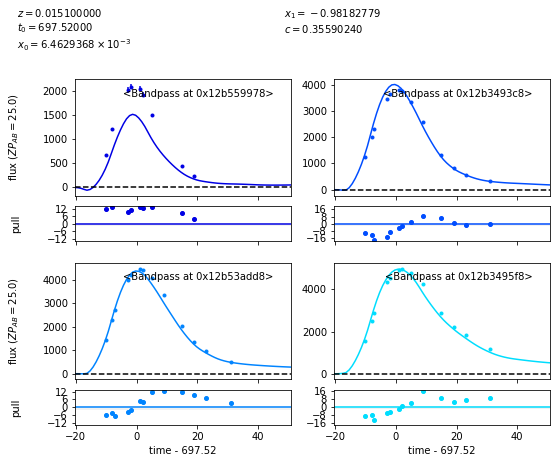

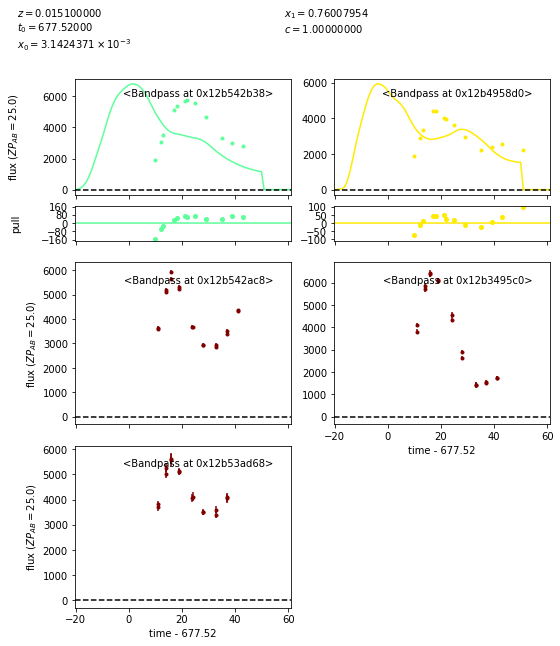

In [7]:
def plot_fitted_csp(cid, model, num_params):

    data = csp.get_input_for_id(cid)
    data_list = [data]
    data_list.extend(split_data(data, csp.band_names, csp.lambda_effective))
    fit_result_list = get_fit_results('csp', model, num_params, data_dir)
    
    for data, result_table in zip(data_list, fit_result_list):
        fit_results = result_table.loc[cid]
        model_args = {param: fit_results[param] for param in model.param_names}
        model = deepcopy(model)
        model.set(**model_args)
    
        sncosmo.plot_lc(data, model=model)
        plt.show()

        
plot_fitted_csp('2005kc', salt_2_4, 4)


## Plotting functions

Since we will be creating the same plots for multiple data sets, we create some generic plotting functions. We create a static version of the plot zoomed in to show detail, along with an interactive version that defaults to show all available data. Note that we assume the colum names of the data tables being plotted.

In [ ]:
def create_static_figure(fit_data, survey_name):
    """Return a matplotlib figure comparing x0, x1, c, and chisq
    of the published and SNCosmo fit values.
    
    Args:
        fit_data  (Table): A table of data to plot
        survey_name (str): Name of the survey being plotted
        
    Returns:
         A matplotlib figure object
    """

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    line = (-20, 60000)

    
    
    for axis, value in zip(axes, ['t0', 'x0', 'x1', 'c']):
        axis.set_title(value)
        axis.plot(line, line, linestyle='--', color='grey', alpha=.6)
        axis.errorbar(fit_data[f'{value}_{survey_name}'],
                      fit_data[f'{value}_sncosmo'],
                      xerr=fit_data[f'{value}_err_{survey_name}'],
                      yerr=fit_data[f'{value}_err_sncosmo'],
                      linestyle='',
                      alpha=.3)
        
        axis.scatter(fit_data[f'{value}_{survey_name}'],
                     fit_data[f'{value}_sncosmo'],
                     alpha=.3,
                     s=5)

    reduced_chisq_survey = (
        fit_data[f'chi_{survey_name}'] / 
        fit_data[f'dof_{survey_name}']
    )

    reduced_chisq_sncosmo = fit_data['chi_sncosmo'] / fit_data['dof_sncosmo']
    axes[4].set_title('chisq')
    axes[4].plot(line, line, linestyle='--', color='grey', alpha=.8)
    axes[4].scatter(fit_data[f'chi_{survey_name}'],
                    fit_data['chi_sncosmo'],
                    alpha=.3, s=10)

    axes[5].set_title('chisq_norm')
    axes[5].plot(line, line, linestyle='--', color='grey', alpha=.8)
    axes[5].scatter(reduced_chisq_survey,
                    reduced_chisq_sncosmo,
                    alpha=.3, s=10)

    
    axes[0].set_ylabel('SNCosmo Fit ugriz')
    axes[3].set_xlabel('Published Value')
    axes[3].set_ylabel('SNCosmo Fit ugriz')
    axes[4].set_xlabel('Published Value')
    axes[5].set_xlabel('Published Value')

    return axes


def create_interactive_figure(fit_data, survey_name):
    """Return a bokeh figure comparing x0, x1, c, and chisq
    of the published and SNCosmo fit values.
    
    Args:
        fit_data  (Table): A table of data to plot
        survey_name (str): Name of the survey being plotted
        
    Returns:
         A bokeh figure object
    """

    data_dict = fit_data.copy()
    data_dict['chisq_norm_sncosmo'] = (
        data_dict['chi_sncosmo'] / data_dict['dof_sncosmo']
    )

    data_dict[f'chisq_norm_{survey_name}'] = (
        data_dict[f'chi_{survey_name}'] / 
        data_dict[f'dof_{survey_name}']
    )
    
    source = ColumnDataSource(data=data_dict)
    hover = HoverTool(tooltips=[
        ("target", "@cid"),
        ("class", "@class"),
        ("z", "@z"),
        ('z_fit', '@fit_z'),
        ('chisq_sncosmo', '@chisq_sncosmo'),
        ('ndof_sncosmo', '@ndof_sncosmo'),
    ])

    figures = []
    for value in ('x0', 'x1', 'c', 'chisq_norm'):
        x_key, y_key = f'{value}_{survey_name}', f'{value}_sncosmo'
        fig = figure(
            tools=_basic_tools + [hover, 'box_select', 'lasso_select'],
            title=value)
        
        fig.circle(x_key, y_key, source=source, size=4, alpha=.5)
        fig.line([min(data_dict[x_key]), max(data_dict[x_key])],
                 [min(data_dict[x_key]), max(data_dict[x_key])],
                 line_width=2)

        fig.xaxis.axis_label = 'Published Value'
        fig.yaxis.axis_label = 'SNCosmo Fit ugriz'
        figures.append(fig)

    return gridplot(figures, ncols=2, plot_width=350, plot_height=350)


## SDSS

We create a table to store both the published and SNCosmo fit results for SDSS. Then we plot correlations between both data sets for the fit parameters x0, x1 (stretch), and c (color) along with normalized chi-squared.

In [ ]:
# Get SDSS published data
sdss_published = sdss.master_table[
    'CID',
    'PeakMJDSALT2zspec',
    'PeakMJDderrSALT2zspec',
    'x0SALT2zspec',
    'x0errSALT2zspec',
    'x1SALT2zspec',
    'x1errSALT2zspec',
    'cSALT2zspec',
    'cerrSALT2zspec',
    'chi2SALT2zspec',
    'ndofSALT2zspec'
]

sdss_published = sdss_published.to_pandas()
sdss_published.dropna(inplace=True)
sdss_published.rename(index=str, inplace=True, columns={
    'CID': 'cid',
    'PeakMJDSALT2zspec': 't0_sdss',
    'PeakMJDderrSALT2zspec': 't0_err_sdss',
    'x0SALT2zspec': 'x0_sdss',
    'x0errSALT2zspec': 'x0_err_sdss',
    'x1SALT2zspec': 'x1_sdss',
    'x1errSALT2zspec': 'x1_err_sdss',
    'cSALT2zspec': 'c_sdss',
    'cerrSALT2zspec': 'c_err_sdss',
    'chi2SALT2zspec': 'chi_sdss',
    'ndofSALT2zspec': 'dof_sdss'})

sdss_published.set_index('cid', inplace=True)

# Join table with SNCosmo fit data
sdss_snia_4param_all, _, _ = get_fit_results('sdss', salt_2_0, 4, data_dir)
sdss_snia_4param_all.dropna(inplace=True)
sdss_snia_4param_all.columns = sdss_snia_4param_all.columns.map(lambda x: str(x) + '_sncosmo')

combined_sdss = sdss_published.join(sdss_snia_4param_all)


In [ ]:
plot_axes = create_static_figure(combined_sdss, 'sdss')

# Note that the bounds for axis 0 only show onne observing season
plot_axes[0].set_xlim(53940, 54080)
plot_axes[0].set_ylim(53940, 54080)
plot_axes[1].set_xlim(0, .003)
plot_axes[1].set_ylim(0, .003)
plot_axes[2].set_xlim(-6, 6)
plot_axes[2].set_ylim(-6, 6)
plot_axes[3].set_xlim(-1.5, 1.5)
plot_axes[3].set_ylim(-1.5, 1.5)
plot_axes[4].set_xlim(0, 200)
plot_axes[4].set_ylim(0, 200)
plot_axes[5].set_xlim(0, 5)
plot_axes[5].set_ylim(0, 5)

plt.savefig(os.path.join(fig_dir, 'sdss_compare_published.pdf'))
plt.show()


In [ ]:
plot_grid = create_interactive_figure(combined_sdss, 'sdss')
show(plot_grid)


Note the disagreement of the `x0` values. Having no explanation, for the time being, we settle on characterizing the slope of the relationship and move on.

In [ ]:
x = combined_sdss['x0_sdss']
y = combined_sdss['x0_sncosmo']
is_not_nan = ~np.isnan(y)
np.polyfit(x[is_not_nan], y[is_not_nan], 1)


## DES

In [ ]:
# Get DES published data
des_published = des.master_table[
    'CID',
    'PKMJD',
    'PKMJDERR',
    'x0',
    'x0ERR',
    'x1',
    'x1ERR',
    'c',
    'cERR',
    'FITCHI2',
    'NDOF'
]

des_published = des_published.to_pandas()
des_published.dropna(inplace=True)
des_published.rename(index=str, inplace=True, columns={
    'CID': 'cid',
    'PKMJD': 't0_des',
    'PKMJDERR': 't0_err_des',
    'x0': 'x0_des',
    'x0ERR': 'x0_err_des',
    'x1': 'x1_des',
    'x1ERR': 'x1_err_des',
    'c': 'c_des',
    'cERR': 'c_err_des',
    'FITCHI2': 'chi_des',
    'NDOF': 'dof_des'})

des_published.set_index('cid', inplace=True)

# Join table with SNCosmo fit data
des_snia_4param_all, _, _ = get_fit_results('des', salt_2_4, 4, data_dir)
des_snia_4param_all.columns = des_snia_4param_all.columns.map(lambda x: str(x) + '_sncosmo')
des_snia_4param_all.index = des_snia_4param_all.index.map(str)

combined_des = des_published.join(des_snia_4param_all)


In [ ]:
plot_axes = create_static_figure(combined_des, 'des')

plot_axes[0].set_xlim(56800, 57200)
plot_axes[0].set_ylim(56800, 57200)
plot_axes[1].set_xlim(0, 6e-4)
plot_axes[1].set_ylim(0, 6e-4)
plot_axes[2].set_xlim(-5, 5)
plot_axes[2].set_ylim(-5, 5)
plot_axes[3].set_xlim(-.4, .4)
plot_axes[3].set_ylim(-.4, .4)
plot_axes[4].set_xlim(0, 70)
plot_axes[4].set_ylim(0, 200)
plot_axes[5].set_xlim(0, 2)
plot_axes[5].set_ylim(0, 8)

plt.savefig(os.path.join(fig_dir, 'des_compare_published.pdf'))
plt.show()


In [ ]:
plot_grid = create_interactive_figure(combined_des, 'des')
show(plot_grid)
